## Trabalho da disciplina Álgebra e Criptografia - Implementação do RSA

#### O que é o RSA? 

O algoritmo RSA é um dos métodos de criptografia de chave pública mais conhecido e amplamente utilizado para transmissão segura de dados. Seu objetivo é proteger dados e garantir autenticidade em diversas aplicações, como comunicação segura e assinaturas digitais.

Ele foi desenvolvido em 1977 por Ron Rivest, Adi Shamir e Leonard Adleman cujas iniciais formam o nome "RSA" que atuavam como pesquisadores do Massachusetts Institute of Technology (MIT).

Tal método nos permite codificar uma mensagem utilizando o produto de dois números primos, e para decodificá-la é necessário conhecer estes primos, ou seja, decifrar a mensagem consiste em fatorar o número que é o produto dos primos usados na fase de codificação. Por isso, utilizar como chave de codificação números primos grandes faz com que a tarefa de decodificar a mensagem seja difícil e tenha alto custo computacional.


### Como funciona o RSA?

Ele utiliza um par de chaves: uma pública $(n,e)$ que é usada para criptografar e uma privada $(d)$ e é usada para descriptografar.

1. São escolhidos dois primos grandes $p$ e $q$;
2. Calculamos $ n = pq$, que será usado tanto na chave pública quanto na privada;
3. Calculamos a função totiente de Euler: $\phi(n) = (p-1)(q-1)$;
4. Escolhemos um inteiro com $2\leq e<\phi(n)$ e $mdc(e, \phi(n)) =1$, ou seja, $e$ e $\phi(n)$ são coprimos;
5. Dada uma mensagem $m$ com $0 \leq m \leq n-1$, a mensagem codificada é $c = m^e(mod(n))$;
6. Calculamos $d$, que é o inverso multipicativo de $e \mod(\phi(n))$
7. Para codificar é necessário calcular $c^d(mod(n))$.


### Observações importantes:
1. A função $\phi(n)$ calcula a quantidade de elementos invertíveis no grupo $(mod(n))$, que são todos os elementos coprimos com $n = pq$.
2. É necessário que $e$ e $\phi(n)$ sejam coprimos pra que $e$ tenha o inverso multiplicativo no $mod(\phi(n))$
3. Ao descriptografar uma mensagem, $c^d(mod(n)) = m^{e^d}(mod(n)) = m^{ed}(mod(n))$. Como $ed\equiv 1 (mod(\phi(n)))$, podemos reescrever a equação como $m^{\phi(n) + \phi(n) + \dots + \phi(n) + 1 }(mod(n))$.
Aqui, se $mdc(n,m) = 1$, podemos usar o teorema de Euler:
$$
m^{\phi(n)} \equiv 1 (mod(n))
$$
resultando em $m^{ed} \equiv m (mod(n))$.
Mas se $mdc(m,n) \neq 1$ o sistema pode não funcionar corretamente como vimos na aula online.

### Escolha dos números primos

A escolha dos números primos pode ser feita de forma manual ou automática, dependendo do valor da variável booleana `generate_primes`. Se `generate_primes` for `True`, o código irá gerar aleatoriamente um número grande com o número de bits especificado e testar sua primalidade usando a função `isprime`. Caso o número gerado não seja primo, o código continuará gerando novos números até encontrar um primo válido, atendendo às especificações necessárias. Se, por outro lado, a variável `generate_primes` for `False`, o usuário deverá fornecer manualmente os dois números primos que serão utilizados, isso é útil se tivermos um método terceiro de geradores de primos grandes ( trabalho da Marceli Melchiors e do Daniel Falqueto ou o trabalho do Ademir, Juliane e Erlon).

### Algoritmo Estendido de Euclides

O algoritmo estendido de Euclides é uma extensão do algoritmo de Euclides que não só encontra o máximo divisor comum (MDC) mas também os coeficientes de Bézout, ou seja, $\alpha\ ,\beta \in \mathbb{Z}$ tais que $\alpha a + \beta b = mdc(a,b) $.
Por isso ele é usado em criptografia para verificar se dois números são coprimos e encontrar coeficientes $\alpha$ e $\beta$ que satisfazem $\alpha a + \beta b = 1$

Ele funciona de forma iterativa e se baseia na fórmula do algoritmo de Euclides clássico incorporando $\alpha$ e $\beta$: 

$$ mdc(a,b) = mdc(b, a \mod (b)).$$

1. Se b=0, então:

$$mdc(a,b) = a, \alpha =1, \beta = 0$$

2. Caso contrário:
   - Use a fórmula $\text{MDC}(a, b) = \text{MDC}(b, a \mod b)$.
   
   - Resolva recursivamente $ b \cdot \alpha_1 + (a \mod b) \cdot \beta_1 = \text{MDC}(b, a \mod b) $.

   - Expanda $ a \mod b $ usando $ a \mod b = a - \lfloor a / b \rfloor \cdot b $:
     $$     a \cdot \beta_1 + b \cdot (\alpha_1 - \lfloor a / b \rfloor \cdot \beta_1) = \text{MDC}(a, b)     $$


   - Os novos coeficientes são:
     $$\alpha= \beta_1, \quad \alpha = \alpha_1 - \lfloor a / b \rfloor \cdot \beta_1    $$


## Abordagem em blocos

O RSA opera sobre números inteiros, e o tamanho máximo da mensagem que pode ser criptografada é determinado pelo valor de n, que é o produto de dois números primos grandes. Como o RSA só pode manipular números menores que n, mensagens maiores que esse valor precisam ser divididas em blocos menores para que cada um deles possa ser criptografado ou descriptografado de forma independente. Cada bloco é convertido para um número inteiro, criptografado com a chave pública e, no caso da descriptografia, revertido para sua forma original.

Essa abordagem é necessária porque, no RSA, a operação de criptografia e descriptografia depende de um valor n que tem um limite de tamanho. Portanto, a mensagem deve ser dividida em partes que caibam nesse limite. Além disso, ao dividir a mensagem em blocos, é possível criptografar ou descriptografar grandes volumes de dados sem perder a integridade da informação. A divisão facilita o processamento de mensagens grandes, pois permite que cada bloco seja tratado de maneira independente, o que pode otimizar o tempo de processamento, principalmente em sistemas com grandes volumes de dados. Essa técnica também abre caminho para a utilização do RSA em cenários práticos, onde a criptografia de textos longos ou arquivos inteiros seria inviável se o algoritmo operasse sobre uma única unidade de dados. A divisão em blocos, portanto, torna o RSA aplicável e seguro para o uso em sistemas de criptografia modernos.

## Encriptografia

O método `encrypt` tem como objetivo criptografar uma mensagem (texto plano) utilizando a chave pública do RSA. O processo é feito da seguinte maneira: primeiro, ele obtém a chave pública, que consiste nos valores $ e$ e $ n $. O código então calcula o tamanho máximo de cada bloco de mensagem que pode ser criptografado, com base no número de bits de $ n $, garantindo que cada bloco caiba dentro da capacidade do sistema de criptografia.

Em seguida, a mensagem é convertida para bytes utilizando a codificação UTF-8. A mensagem em bytes é dividida em blocos menores, de acordo com o tamanho máximo calculado. Cada bloco é processado individualmente: o bloco de bytes é convertido para um número inteiro (utilizando a função `int.from_bytes`), e esse número é criptografado aplicando a fórmula $ \text{ciphertext} = \text{plaintext}^e \mod n $, onde $ e $ e $ n $ fazem parte da chave pública. O bloco criptografado é então armazenado na lista `ciphertext_blocks`.

O método retorna essa lista de blocos criptografados, que representam a mensagem cifrada. Esse processo de dividir a mensagem em blocos permite que mensagens de qualquer tamanho possam ser criptografadas, mesmo que o valor de \( n \) não permita criptografar a mensagem inteira de uma vez.

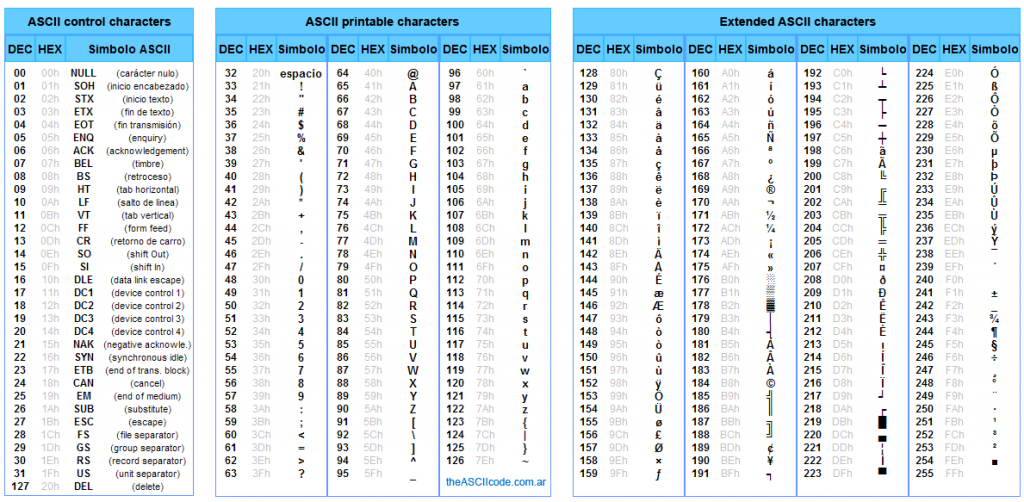

## Decriptografia 

O método `decrypt` tem como objetivo descriptografar uma lista de blocos de texto cifrado utilizando a chave privada do RSA. A chave privada, composta pelos valores $ d $  e $ n $ , é usada para reverter o processo de criptografia e recuperar a mensagem original. O processo ocorre da seguinte forma:

Primeiro, o método recebe como entrada uma lista de blocos criptografados, onde cada bloco é um número inteiro. Para cada bloco, o código aplica a fórmula de descriptografia $ \text{plaintext} = \text{ciphertext}^d \mod n $, onde $ d $ e $ n $ fazem parte da chave privada.

Após a descriptografia de cada bloco, o número resultante (que ainda é em formato inteiro) é convertido novamente para bytes utilizando a função `to_bytes`. Isso é feito para garantir que a mensagem descriptografada, que originalmente foi convertida para bytes, seja restaurada corretamente. Os bytes de cada bloco são então concatenados para formar a mensagem inteira.

Finalmente, a sequência de bytes é convertida de volta para uma string usando a codificação UTF-8 e a mensagem original é retornada.

Esse processo permite que a mensagem original, dividida em blocos e criptografada, seja corretamente recuperada após a descriptografia.

In [11]:
import random
# from Crypto.Util.number import getPrime, inverse, GCD
from sympy import isprime
from math import gcd

Os métodos descritos anteriormente foram implementados em uma classe que chamamos de RSA.

In [ ]:
class RSA:
    def __init__(self, bit_length=1024, generate_primes = True, first_prime = None, second_prime = None):
        self.bit_length = bit_length
        self.public_key = None
        self.private_key = None
        self.n = None
        self.generate_primes = generate_primes
        self.first_prime = first_prime
        self.second_prime = second_prime


    def extended_euclid(a, b):

        """
        Implementação do algoritmo estendido de Euclides do zero.
        
        Calcula o máximo divisor comum (MDC) entre a e b e os coeficientes de Bézout.
        
        Args:
            a (int): Primeiro número.
            b (int): Segundo número.
        
        Returns:
            tuple: (mdc, x, y), onde:
                mdc -> Máximo divisor comum entre a e b.
                x, y -> Coeficientes de Bézout tais que a * x + b * y = mdc.
        """
        x0, y0, x1, y1 = 1, 0, 0, 1  # Inicialização dos coeficientes de Bézout
        while b != 0:
            q = a // b  # Quociente da divisão inteira
            a, b = b, a % b  # Atualiza a e b usando o algoritmo de Euclides
            x0, x1 = x1, x0 - q * x1  # Atualiza os coeficientes x
            y0, y1 = y1, y0 - q * y1  # Atualiza os coeficientes y
        return a # a é o MDC, x0 e y0 são os coeficientes de Bézout
    
    def generate_prime(self):
        """Gera um número primo aleatório com o tamanho de bits especificado."""
        while True:
            num = random.getrandbits(self.bit_length // 2) # 2 números gerados, // significa div inteira
            if isprime(num): # verifica se os numeros são primos
                return num
    
    def generate_keys(self):
        """Gera as chaves pública e privada."""
        p=0
        q=0
        if self.generate_primes == True:  # Certifique-se de verificar o nome correto do atributo
            p = self.generate_prime()
            q = self.generate_prime()
        else:
            if self.first_prime is None or self.second_prime is None:
                raise ValueError("Você deve fornecer os dois números primos se 'generate_primes' for False.")
            p = self.first_prime
            q = self.second_prime
        
        self.n = p * q #parte 1 da chave pública
        phi = (p - 1) * (q - 1) # 
        
        # Escolha um 'e' tal que 1 < e < phi e gcd(e, phi) == 1
        # e = 65537  # Valor padrão usado na prática (é primo)
        e = 97
        if phi<=e:
            raise ValueError("Você precisa que e seja menor que phi. \n" +
                            "Por favor, selecione números primos maiores ou " +
                            "escolha uma chave e menor.")

        if RSA.extended_euclid(e, phi) != 1: #função que verifica o MDC entre dois números
            raise ValueError("e não é coprimo com φ(n), tente gerar os primos novamente.")
        
        # Calcula o 'd' (chave privada)
        d = pow(e, -1, phi)
        
        self.public_key = (e, self.n)
        self.private_key = (d, self.n)
    
    def encrypt(self, plaintext):
        """Criptografa uma mensagem, dividindo-a em blocos se necessário."""
        e, n = self.public_key
        max_block_size = (n.bit_length() - 1) // 8  # Calcula o tamanho máximo do bloco em bytes

        # Divide a mensagem em blocos menores que o tamanho máximo
        plaintext_bytes = plaintext.encode('utf-8')
        blocks = [plaintext_bytes[i:i + max_block_size] for i in range(0, len(plaintext_bytes), max_block_size)]

        # Criptografa cada bloco individualmente
        ciphertext_blocks = []
        for block in blocks:
            plaintext_int = int.from_bytes(block, byteorder='big')  # Converte o bloco para inteiro
            ciphertext = pow(plaintext_int, e, n)  # Criptografa o bloco
            ciphertext_blocks.append(ciphertext)

        return ciphertext_blocks  # Retorna a lista de blocos criptografados

    
    def decrypt(self, ciphertext_blocks):
        """
        Descriptografa uma lista de blocos criptografados.
        
        Args:
            ciphertext_blocks (list): Lista de blocos criptografados como inteiros.
        
        Returns:
            str: Mensagem descriptografada como string.
        """
        d, n = self.private_key

        # Descriptografa cada bloco
        plaintext_bytes = b""
        for block in ciphertext_blocks:
            plaintext_int = pow(block, d, n)  # Descriptografa o bloco
            block_bytes = plaintext_int.to_bytes((plaintext_int.bit_length() + 7) // 8, byteorder='big')
            plaintext_bytes += block_bytes  # Junta os bytes de cada bloco

        return plaintext_bytes.decode('utf-8')  # Converte para string

    
    def get_public_key(self):
        """Retorna a chave pública."""
        return self.public_key
    
    def get_private_key(self):
        """Retorna a chave privada."""
        return self.private_key

In [13]:

# Demonstração de uso
#Por favor não substitua os primos abaixo do exemplo (23,29)
if __name__ == "__main__":
    rsa = RSA(generate_primes=False, first_prime=23, second_prime=29)
    rsa.generate_keys()
    
    print("Chave pública:", rsa.get_public_key())
    print("Chave privada:", rsa.get_private_key())
    
    # mensagem = "Hello, RSA!"
    mensagem = "Daniel Jacob passou para o mestrado no IMPA e na PUC UHUUUL."
    print("\nMensagem original:", mensagem)
    
    criptografada = rsa.encrypt(mensagem)
    print("Mensagem criptografada:", criptografada)
    
    descriptografada = rsa.decrypt(criptografada)
    print("Mensagem descriptografada:", descriptografada)

Chave pública: (97, 667)
Chave privada: (489, 667)

Mensagem original: Daniel Jacob passou para o mestrado no IMPA e na PUC UHUUUL.
Mensagem criptografada: [229, 287, 633, 95, 2, 330, 48, 310, 287, 360, 516, 108, 48, 442, 287, 115, 115, 516, 581, 48, 442, 287, 160, 287, 48, 516, 48, 352, 2, 115, 116, 160, 287, 9, 516, 48, 633, 516, 48, 404, 32, 410, 286, 48, 2, 48, 633, 287, 48, 410, 537, 477, 48, 537, 524, 537, 537, 537, 153, 46]
Mensagem descriptografada: Daniel Jacob passou para o mestrado no IMPA e na PUC UHUUUL.


# Dinâmica 

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
# Configurar o Selenium
driver = webdriver.Chrome()  # Certifique-se de ter o ChromeDriver instalado e configurado
driver.get("https://web.whatsapp.com/")

# Aguarde o QR Code ser escaneado
print("Escaneie o QR Code para acessar o WhatsApp Web")
time.sleep(25)  # Ajuste conforme necessário

# Encontre o contato e abra o chat

# contatos = [
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv',
#     'wendell fgv'
# ]

contatos = [
    'ademir fgv',
    'falqueto fgv',
    'csillag fgv',
    'edilton fgv',
    'erlon fgv',
    'iara fgv',
    'janaina fgv',
    'juliana fgv',
    'juliane fgv',
    'lucas fgv',
    'luciano fgv',
    'marceli fgv',
    'sofia fgv',
    'pedro fgv']

primos = [
 (97, 101),
 (97, 103),
 (97, 107),
 (97, 109),
 (97, 113),
 (97, 127),
 (97, 131),
 (97, 137),
 (97, 139),
 (97, 149),
 (97, 151),
 (97, 157),
 (97, 163),
 (97, 167),
 (97, 173)]

# mensagens = [
#     "Amar não é pecado, e se eu estiver errado, que se dane o mundo eu só quero você! <3",
#     "Rosas são vermelhas, violetas são azuis... como eu não faço uma piada sexual?",
#     "Eu adoro pamonha vc gosta de cuzcuz"
# ]
mensagens = [
    "Nunca conversamos em sala, mas tu parece ser muito gente boa! Anda muito bem arrumado!",
    "Já achou sua carteira? Reclama com a Cássia que a Luziel não fez nada sobre isso! kkkkkkk",
    "Ficou devendo encontrar o acervo do IMPA com as provas antigas de otimização... Mas deu tudo certo, amém!",
    "Tu esqueceu de ir fazer a prova de Rn ontem?",
    "Tentei pensar em algo que não fosse relacionado ao seu bigode, mas não dá. Ele é marcante!",
    "Espero que sua perna nunca mais tenha problemas, estamos jogando boas energias!",
    "Mengão chegou no g4 do brasileirão, mas acho que não ganha não :/",
    "Pra vc não vou mandar nada especial não",
    "Parabéns pelo noivado!!! <3",
    "Charuto de chimarrão, já testou? Tendência no mercado.",
    "Obrigado pela disciplina! Foi muito proveitosa! Mas e as provas, vai corrigir quando?",
    "Lá em casa a gente conversa",
    "Como anda o estágio? Tá gostando? Espero que sim! Tempo que não conversamos com calma",
    "A gente lava, mas não apaga / O peso que ele carrega, a dor que traga. / Pisa firme, sem nunca hesitar, / Sabe quem é? É o pé, a caminhar."
    ]


chaves_privadas = []


def localizar_contato(driver, contato):
    try:
        # Localizar a barra de pesquisa e digitar o nome do contato
        barra_pesquisa = driver.find_element(By.XPATH, "//div[@contenteditable='true' and @data-tab='3']")
        barra_pesquisa.clear()
        barra_pesquisa.send_keys(contato)
        time.sleep(2)  # Aguarde a lista atualizar
        
        # Selecionar o primeiro contato que aparece como resultado
        contato_element = driver.find_element(By.XPATH, f"//span[@title='{contato}']")
        return contato_element
    except NoSuchElementException:
        print(f"Contato '{contato}' não encontrado.")
        return None

# Loop para enviar mensagens a múltiplos contatos
for i in range(len(contatos)):

    # Inicializar RSA e gerar chaves
    rsa = RSA(bit_length=512, generate_primes=False, first_prime=primos[i][0], second_prime=primos[i][1])
    rsa.generate_keys()
    chaves_privadas.append(rsa.get_private_key())

    #Definindo mensagem e contato
    contato = contatos[i]
    # Criptografar a mensagem
    mensagem = f'''
    Olá {contato.replace(" fgv", "")}!
    Espero que esteja gostando da nossa apresentação! Tenho uma mensagem pra você: 
    {mensagens[i]}
    Obrigado por interagir com a gente, {contato.replace(" fgv", "")}! ;)
    '''
    # mensagem = r"""
    #    /|       |\
    # `__\\       //__'
    #    ||      ||
    #  \__`\     |'__/
    #   `_\\   //_'
    #   _.,:---;,._
    #   \_:     :_/
    #     |@. .@|
    #     |     |
    #     ,\.-./ \
    #     ;;`-'   `---__________-----.-.
    #     ;;;                         \_\
    #     ';;;                         |
    #     ;    |                      ;
    #     \   \     \        |      /
    #         \_, \    /        \     |\
    #         |';|  |,,,,,,,,/ \    \ \_
    #         |  |  |           \   /   |
    #         \  \  |           |  / \  |
    #         | || |           | |   | |
    #         | || |           | |   | |
    #         | || |           | |   | |
    #         |_||_|           |_|   |_|
    #         /_//_/           /_/   /_/
    # """

    #Criptografa a mensagem
    criptografada = rsa.encrypt(mensagem)
    mensagem_enviar = " ".join(map(str, criptografada))

    #Envia a mensagem
    print(f"Enviando para o contato {contato}.")
    # Localizar e clicar no contato
    try:
        contato_element = localizar_contato(driver, contato)
        if contato_element:
            contato_element.click()
            time.sleep(5)
        else:
            print(f"Contato '{contato}' não encontrado. Verifique o nome e tente novamente.")
            continue
    except Exception as e:
        print(f"Erro ao tentar localizar o contato '{contato}': {e}.")
        continue  # Pula para o próximo contato

    # Enviar a mensagem no campo
    try:
        caixa_mensagem = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//footer//div[@contenteditable='true']"))
        )
        caixa_mensagem.click()

        # Enviar a primeira mensagem
        caixa_mensagem.send_keys("Mensagem criptografada:")
        caixa_mensagem.send_keys(Keys.ENTER)

        time.sleep(1)

        # Enviar a mensagem criptografada
        caixa_mensagem.send_keys(f"\"{mensagem_enviar}\"")
        caixa_mensagem.send_keys(Keys.ENTER)

        print(f"Mensagem enviada para {contato}.")
    except Exception as e:
        print(f"Erro ao enviar mensagem para '{contato}': {e}.")
        continue

    time.sleep(3)  # Pausa entre contatos
 # Tempo entre mensagens para evitar problemas com o WhatsApp Web

driver.quit()

Escaneie o QR Code para acessar o WhatsApp Web
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o contato wendell fgv.
Mensagem enviada para wendell fgv.
Enviando para o c

In [15]:
# Preparar os dados para a tabela
import pandas as pd

dados_tabela = []
for i, contato in enumerate(contatos):
    # Dados de cada contato
    dados_tabela.append({
        "Contato": contato.replace(" fgv", ""),
        "Tupla de Primos": primos[i],
        "Chave Privada": chaves_privadas[i],
        "Mensagem": mensagens[i]
    })

# Criar um DataFrame com os dados
df = pd.DataFrame(dados_tabela)

# Salvar a tabela em um arquivo Excel
arquivo_saida = "/mnt/data/Mensagens_Enviadas.xlsx"
# df.to_excel(arquivo_saida, index=False)

# Exibir a tabela ao usuário
df

,Contato,Tupla de Primos,Chave Privada,Mensagem
0,wendell,"(97, 101)","(6433, 9797)","Nunca conversamos em sala, mas tu parece ser m..."
1,wendell,"(97, 103)","(3937, 9991)",Já achou sua carteira? Reclama com a Cássia qu...
2,wendell,"(97, 107)","(5665, 10379)",Ficou devendo encontrar o acervo do IMPA com a...
3,wendell,"(97, 109)","(5665, 10573)",Tu esqueceu de ir fazer a prova de Rn ontem?
4,wendell,"(97, 113)","(1441, 10961)",Tentei pensar em algo que não fosse relacionad...
5,wendell,"(97, 127)","(10849, 12319)",
6,wendell,"(97, 131)","(6433, 12707)","Mengão chegou no g4 do brasileirão, mas acho q..."
7,wendell,"(97, 137)","(673, 13289)",Pra vc não vou mandar nada especial não
8,wendell,"(97, 139)","(9697, 13483)",Parabéns pelo noivado!!! <3
9,wendell,"(97, 149)","(11425, 14453)",
